In [1]:
#!jupyter nbconvert --to script SNR_analysis.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from sklearn.metrics import pairwise_distances# Load your DataFrame (result_df) if you haven't already
import os

import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy import stats


import numpy as np

In [2]:
MODEL_NAME = 'EDA'
RUN = 'run0_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = r'/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery/
/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery_dissertation/output/run0_EDA/


In [3]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    array
        Array of ECG features: [mean heart rate, maximum heart rate, minimum heart rate, heart rate variability].
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) == 0:
        raise ValueError("No R-peaks detected in ECG signal.")
    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if heart_rate.size == 0:
        raise ValueError("Error computing heart rate from ECG signal.")
    
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))

    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 4.0

    # Remove outliers from the valid_heart_rate array
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    d_rr_ms = 1000 * d_rr
    d_d_rr_ms = np.diff(d_rr_ms)

    valid_d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(valid_d_d_rr_ms))
    d_d_rr_ms= valid_d_d_rr_ms[z_scores <= z_score_threshold]
    heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))

    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.1 # 1 second before the RR interval
        end_time = rr_interval + 0.1   # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

     # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)
    
    return hr_mean, hr_max, hr_min, heart_rate_variability, snr_values

In [3]:
ECG_FEATURES_LIST = 'ecg_data'

# data is pandas.DataFrame
# ml_model should have predict method
def ecg_online_prediction(data,ml_model,begin = 0, predict_interval = 250, features = ECG_FEATURES_LIST):
    cutoff_db_snr = 4 
    cutoff_hr_mean = 180
    cutoff_hr_variability = 250
    fs = 250
    
    samples_list = []
    online_predict = []
    end = begin + (250 * 30)
    

    
    #standardlizing
    samples_list = np.array(samples_list)
    if len(samples_list) == 0:
        return samples_list
        
    ecg_scaler = StandardScaler()
    samples_list_scaled = ecg_scaler.fit_transform(samples_list)
    # predicting
    online_predict = ml_model(samples_list_scaled)
    
    return np.array(online_predict)

In [4]:
DATA_DIR = r'/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery/'
df_ecg = pd.read_pickle(DATA_DIR + "df_sensor.pkl")
df_ecg

,subject_id,data,game_type
0,BVCX,"{'Timestamp': [1710352670.22933, 1710352670.23...",baseline
1,BVCX,"{'Timestamp': [1710354601.587721, 1710354601.5...",enumeration
2,BVCX,"{'Timestamp': [1710354051.4275117, 1710354051....",task_switching
3,BVCX,"{'Timestamp': [1710353155.3258922, 1710353155....",working_memory
4,CVBN,"{'Timestamp': [1710444844.91457, 1710444844.91...",baseline
...,...,...,...
395,YTRE,"{'Timestamp': [1711637723.7361555, 1711637723....",baseline
396,YTRE,"{'Timestamp': [1711638227.2988112, 1711638227....",enumeration
397,YTRE,"{'Timestamp': [1711638904.316353, 1711638904.3...",task_switching
398,YTRE,"{'Timestamp': [1711639671.503046, 1711639671.5...",working_memory


In [ ]:
predict_interval = 250
fs = 250
hr_mean_list = []
hr_max_list = []
hr_min_list = []
hrv_list = []
snr_list = []

for index, row in df_ecg.iterrows():
    current_df = pd.DataFrame(row).T
    print(index, ": ", current_df.shape)
    
    temp_df = current_df['data'].apply(lambda x: pd.Series(x))
    current_df = pd.concat([current_df.drop('data', axis=1), temp_df.drop('eda_data',axis=1)], axis=1)
    current_df = current_df.explode(['Timestamp','ecg_data'])
    current_df = current_df.astype({'Timestamp':'float64','ecg_data': 'float64'})
    
    if current_df.shape[0] == 0:
        continue

    # #interpolation
    temp_df = current_df[['Timestamp','ecg_data']]
    temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='s'))
    temp_df = temp_df.interpolate(method='time',limit = 10)
    current_df[['ecg_data']] = np.array(temp_df[['ecg_data']])


    #generate feature
    begin = 0 
    end = begin + (250 * 30)    
    while begin < (len(current_df) - (250* 30) ):
        temp_ecg = np.array(current_df.iloc[begin:end]['ecg_data'])
        temp_time = np.array(current_df.iloc[begin:end]['Timestamp'])
        
        #filter nan
        if np.isnan(temp_ecg).sum() > 0 or np.isnan(temp_time).sum() > 0:
            begin += predict_interval 
            end = begin + (250 * 30)
            continue
            
        #get ecg feature
        try:
            hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(temp_ecg, temp_time,fs=fs)
        except ValueError as e:
            begin += predict_interval 
            end = begin + (250 * 30)
            continue


        hr_mean_list.append(hr_mean)
        hr_max_list.append(hr_max)
        hr_min_list.append(hr_min)
        hrv_list.append(heart_rate_variability)
        snr_list.append(snr_values)
        
        begin += predict_interval 
        end = begin + (250 * 30)

hr_mean_list = np.array(hr_mean_list)
hr_max_list = np.array(hr_max_list)
hr_min_list = np.array(hr_min_list)
hrv_list = np.array(hrv_list)
snr_list = np.array(snr_list)

0 :  (1, 3)
1 :  (1, 3)
2 :  (1, 3)
3 :  (1, 3)
4 :  (1, 3)
5 :  (1, 3)
6 :  (1, 3)
7 :  (1, 3)
8 :  (1, 3)
9 :  (1, 3)
10 :  (1, 3)
11 :  (1, 3)
12 :  (1, 3)
13 :  (1, 3)
14 :  (1, 3)
15 :  (1, 3)
16 :  (1, 3)
17 :  (1, 3)
18 :  (1, 3)
19 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variabi

20 :  (1, 3)
21 :  (1, 3)
22 :  (1, 3)
23 :  (1, 3)
24 :  (1, 3)
25 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


26 :  (1, 3)
27 :  (1, 3)
28 :  (1, 3)
29 :  (1, 3)
30 :  (1, 3)
31 :  (1, 3)
32 :  (1, 3)
33 :  (1, 3)
34 :  (1, 3)
35 :  (1, 3)
36 :  (1, 3)
37 :  (1, 3)
38 :  (1, 3)
39 :  (1, 3)
40 :  (1, 3)
41 :  (1, 3)
42 :  (1, 3)
43 :  (1, 3)
44 :  (1, 3)
45 :  (1, 3)
46 :  (1, 3)
47 :  (1, 3)
48 :  (1, 3)
49 :  (1, 3)
50 :  (1, 3)
51 :  (1, 3)
52 :  (1, 3)
53 :  (1, 3)
54 :  (1, 3)
55 :  (1, 3)
56 :  (1, 3)
57 :  (1, 3)
58 :  (1, 3)
59 :  (1, 3)
60 :  (1, 3)
61 :  (1, 3)
62 :  (1, 3)
63 :  (1, 3)
64 :  (1, 3)
65 :  (1, 3)
66 :  (1, 3)
67 :  (1, 3)
68 :  (1, 3)
69 :  (1, 3)
70 :  (1, 3)
71 :  (1, 3)
72 :  (1, 3)
73 :  (1, 3)
74 :  (1, 3)
75 :  (1, 3)
76 :  (1, 3)
77 :  (1, 3)
78 :  (1, 3)
79 :  (1, 3)
80 :  (1, 3)
81 :  (1, 3)
82 :  (1, 3)
83 :  (1, 3)
84 :  (1, 3)
85 :  (1, 3)
86 :  (1, 3)
87 :  (1, 3)
88 :  (1, 3)
89 :  (1, 3)
90 :  (1, 3)
91 :  (1, 3)
92 :  (1, 3)
93 :  (1, 3)
94 :  (1, 3)
95 :  (1, 3)
96 :  (1, 3)
97 :  (1, 3)
98 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


99 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


100 :  (1, 3)
101 :  (1, 3)
102 :  (1, 3)
103 :  (1, 3)
104 :  (1, 3)
105 :  (1, 3)
106 :  (1, 3)
107 :  (1, 3)
108 :  (1, 3)
109 :  (1, 3)
110 :  (1, 3)
111 :  (1, 3)
112 :  (1, 3)
113 :  (1, 3)
114 :  (1, 3)
115 :  (1, 3)
116 :  (1, 3)
117 :  (1, 3)
118 :  (1, 3)
119 :  (1, 3)
120 :  (1, 3)
121 :  (1, 3)
122 :  (1, 3)
123 :  (1, 3)
124 :  (1, 3)
125 :  (1, 3)
126 :  (1, 3)
127 :  (1, 3)
128 :  (1, 3)
129 :  (1, 3)
130 :  (1, 3)
131 :  (1, 3)
132 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


133 :  (1, 3)
134 :  (1, 3)
135 :  (1, 3)
136 :  (1, 3)
137 :  (1, 3)
138 :  (1, 3)
139 :  (1, 3)
140 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


141 :  (1, 3)
142 :  (1, 3)
143 :  (1, 3)
144 :  (1, 3)
145 :  (1, 3)
146 :  (1, 3)
147 :  (1, 3)
148 :  (1, 3)
149 :  (1, 3)
150 :  (1, 3)
151 :  (1, 3)
152 :  (1, 3)
153 :  (1, 3)
154 :  (1, 3)
155 :  (1, 3)
156 :  (1, 3)
157 :  (1, 3)
158 :  (1, 3)
159 :  (1, 3)
160 :  (1, 3)
161 :  (1, 3)
162 :  (1, 3)
163 :  (1, 3)
164 :  (1, 3)
165 :  (1, 3)
166 :  (1, 3)
167 :  (1, 3)
168 :  (1, 3)
169 :  (1, 3)
170 :  (1, 3)
171 :  (1, 3)
172 :  (1, 3)
173 :  (1, 3)
174 :  (1, 3)
175 :  (1, 3)
176 :  (1, 3)
177 :  (1, 3)
178 :  (1, 3)
179 :  (1, 3)
180 :  (1, 3)
181 :  (1, 3)
182 :  (1, 3)
183 :  (1, 3)
184 :  (1, 3)
185 :  (1, 3)
186 :  (1, 3)
187 :  (1, 3)
188 :  (1, 3)
189 :  (1, 3)
190 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


191 :  (1, 3)
192 :  (1, 3)
193 :  (1, 3)
194 :  (1, 3)
195 :  (1, 3)
196 :  (1, 3)
197 :  (1, 3)
198 :  (1, 3)
199 :  (1, 3)
200 :  (1, 3)
201 :  (1, 3)
202 :  (1, 3)
203 :  (1, 3)
204 :  (1, 3)
205 :  (1, 3)
206 :  (1, 3)
207 :  (1, 3)
208 :  (1, 3)
209 :  (1, 3)
210 :  (1, 3)
211 :  (1, 3)
212 :  (1, 3)
213 :  (1, 3)
214 :  (1, 3)
215 :  (1, 3)
216 :  (1, 3)
217 :  (1, 3)
218 :  (1, 3)
219 :  (1, 3)
220 :  (1, 3)
221 :  (1, 3)
222 :  (1, 3)
223 :  (1, 3)
224 :  (1, 3)
225 :  (1, 3)
226 :  (1, 3)
227 :  (1, 3)
228 :  (1, 3)
229 :  (1, 3)
230 :  (1, 3)
231 :  (1, 3)
232 :  (1, 3)
233 :  (1, 3)
234 :  (1, 3)
235 :  (1, 3)
236 :  (1, 3)
237 :  (1, 3)
238 :  (1, 3)
239 :  (1, 3)


/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_76861/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_76861/851588282.py:55: RuntimeWarning: Mean o

240 :  (1, 3)
241 :  (1, 3)
242 :  (1, 3)
243 :  (1, 3)
244 :  (1, 3)
245 :  (1, 3)
246 :  (1, 3)
247 :  (1, 3)
248 :  (1, 3)
249 :  (1, 3)
250 :  (1, 3)
251 :  (1, 3)
252 :  (1, 3)


In [ ]:
np.save('hr_mean_list.npy', hr_mean_list)
np.save('hr_max_list.npy', hr_max_list)
np.save('hr_min_list.npy', hr_min_list)
np.save('hr_hrv_list.npy', hrv_list)
np.save('hr_snr_list.npy', snr_list)

# Ploting


In [5]:
hr_mean_list = np.load('hr_mean_list.npy')
hr_max_list = np.load('hr_max_list.npy')
hr_min_list = np.load('hr_min_list.npy')
hrv_list = np.load('hr_hrv_list.npy')
snr_list = np.load('hr_snr_list.npy')

In [6]:
print(hr_mean_list.shape)
print(snr_list.shape)

(218936,)
(218936,)


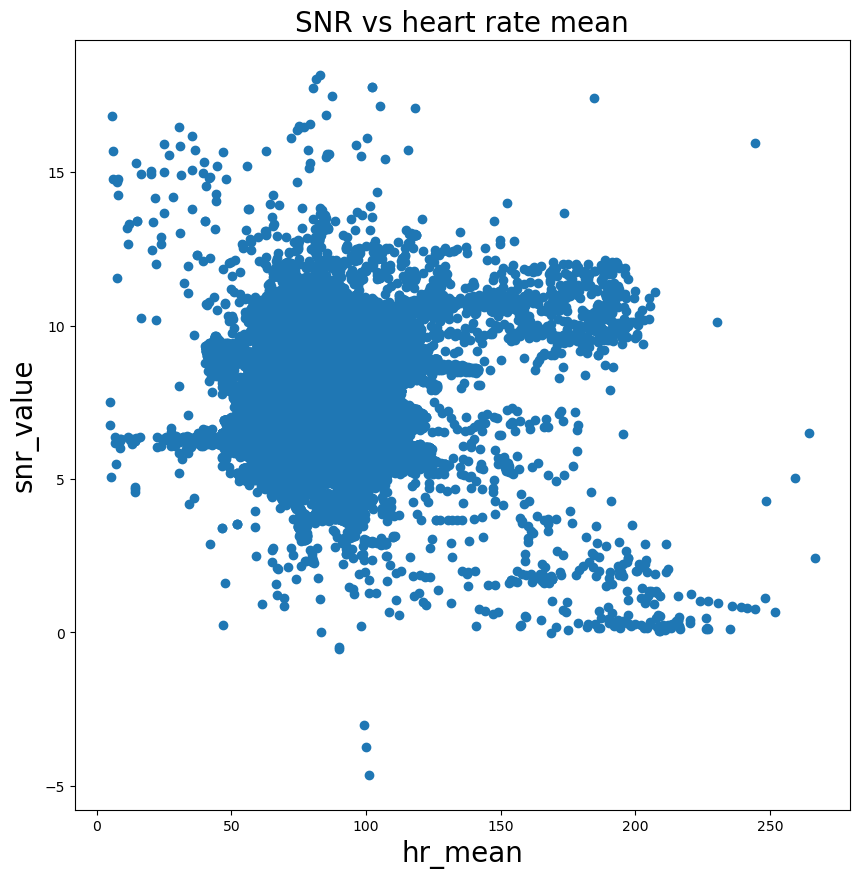

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(hr_mean_list,snr_list)
plt.xlabel("hr_mean",fontsize=20)
plt.ylabel("snr_value",fontsize=20)
plt.title("SNR vs heart rate mean",fontsize=20)
plt.savefig(OUTPUT_DIR + "SNR_VS_hr_mean.png")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming hr_mean_list and snr_list are your data points
X = np.array(list(zip(hr_mean_list, snr_list)))

# List to store silhouette scores for different number of clusters
silhouette_scores = []

# Test cluster sizes from 2 to 10
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Numbers of Clusters', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Silhouette Score', fontsize=15)
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


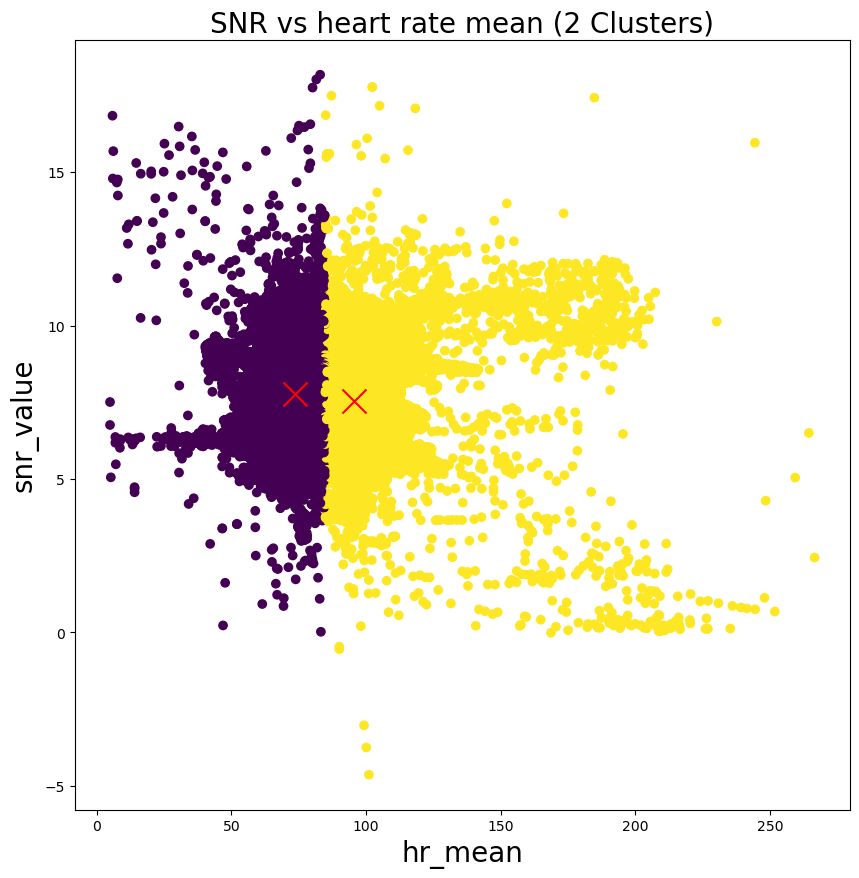

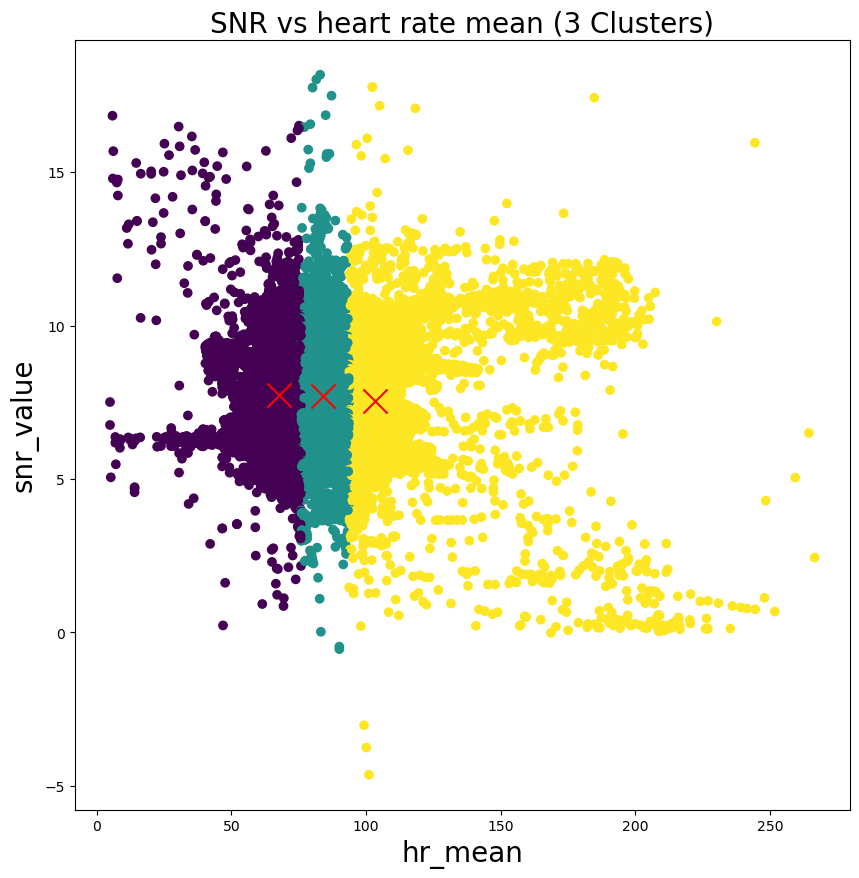

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming hr_mean_list and snr_list are your data points
X = np.array(list(zip(hr_mean_list, snr_list)))

# Clustering into 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(X)
centers_2 = kmeans_2.cluster_centers_

# Clustering into 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X)
centers_3 = kmeans_3.cluster_centers_

# Plotting the clusters with 2 centers
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_2.labels_, cmap='viridis')
plt.scatter(centers_2[:, 0], centers_2[:, 1], s=300, c='red', marker='x')  # Cluster centers
plt.xlabel("hr_mean", fontsize=20)
plt.ylabel("snr_value", fontsize=20)
plt.title("SNR vs heart rate mean (2 Clusters)", fontsize=20)
plt.savefig(OUTPUT_DIR + "SNR_VS_hr_mean_2_clusters.png")
plt.show()

# Plotting the clusters with 3 centers
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_3.labels_, cmap='viridis')
plt.scatter(centers_3[:, 0], centers_3[:, 1], s=300, c='red', marker='x')  # Cluster centers
plt.xlabel("hr_mean", fontsize=20)
plt.ylabel("snr_value", fontsize=20)
plt.title("SNR vs heart rate mean (3 Clusters)", fontsize=20)
plt.savefig(OUTPUT_DIR + "SNR_VS_hr_mean_3_clusters.png")
plt.show()


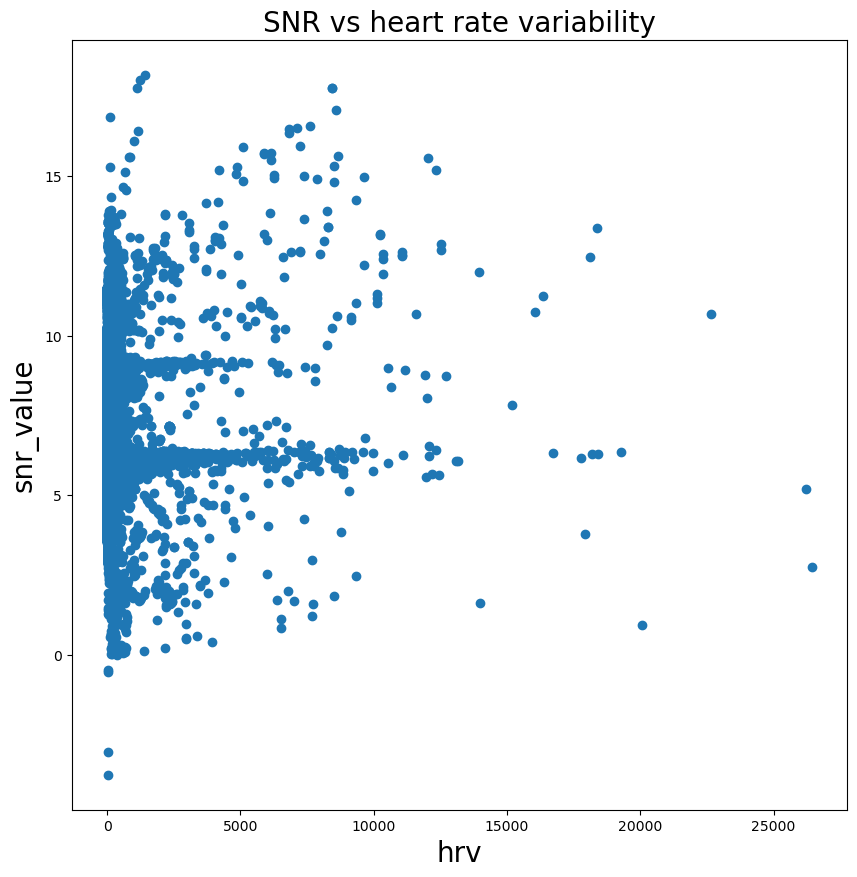

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(hrv_list,snr_list)
plt.xlabel("hrv",fontsize=20)
plt.ylabel("snr_value",fontsize=20)
plt.title("SNR vs heart rate variability",fontsize=20)
plt.savefig(OUTPUT_DIR + "SNR_VS_hrv.png")

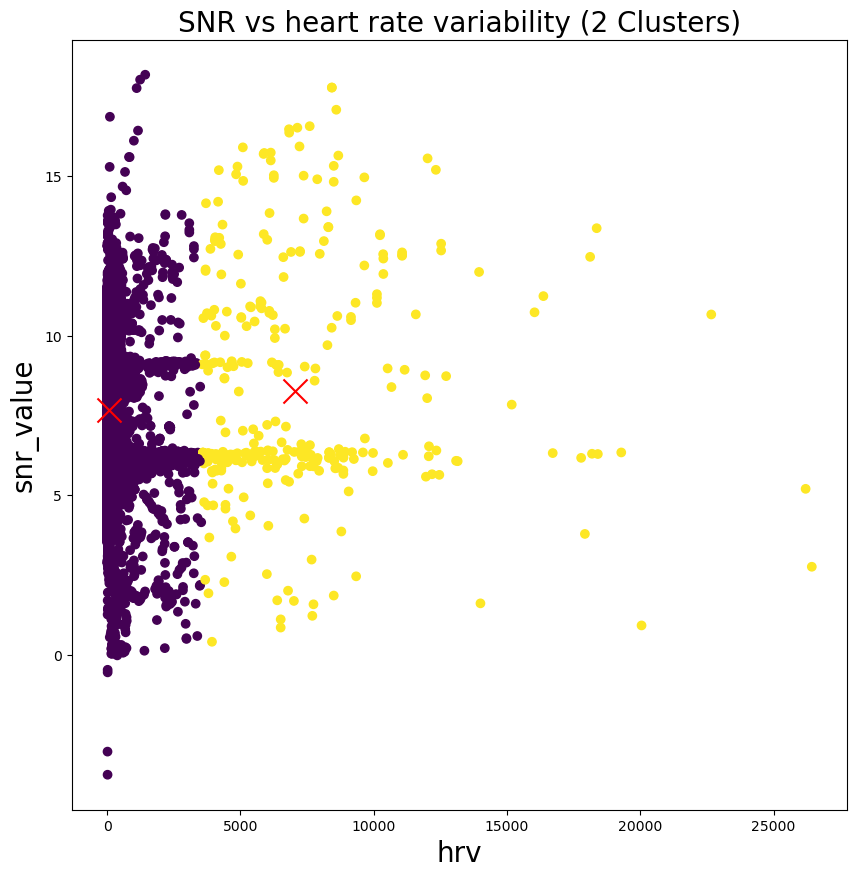

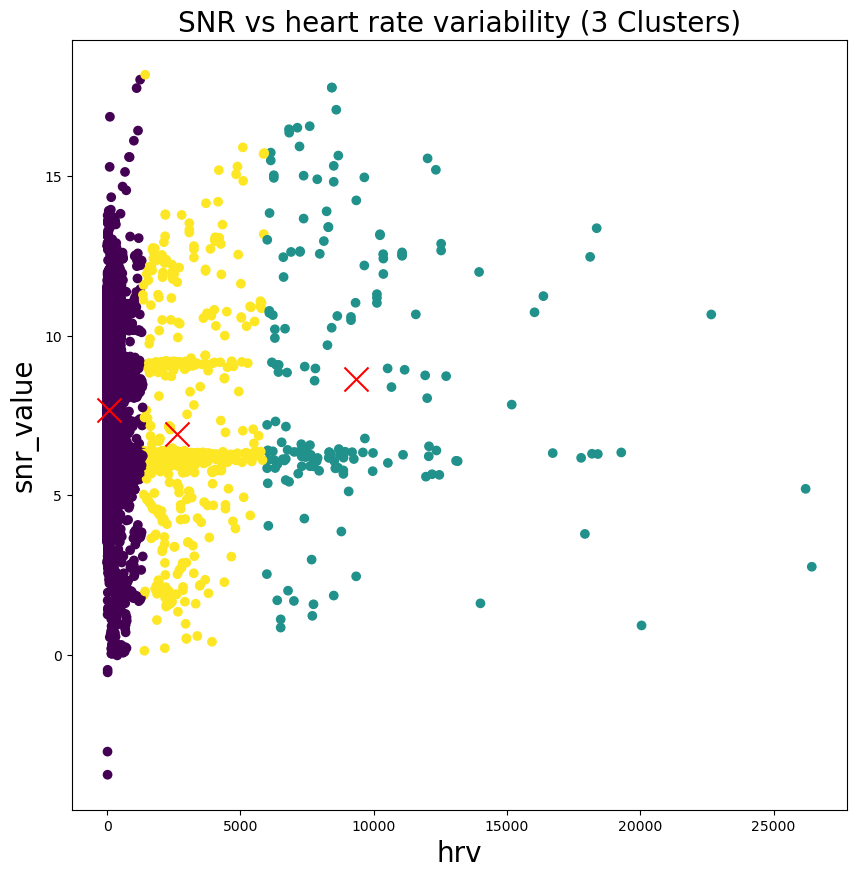

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

mask = ~np.isnan(hrv_list) & ~np.isnan(snr_list)
filtered_hrv = hrv_list[mask]
filtered_snr = snr_list[mask]

# Assuming hr_mean_list and snr_list are your data points
X = np.array(list(zip(filtered_hrv, filtered_snr)))

# Clustering into 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(X)
centers_2 = kmeans_2.cluster_centers_

# Clustering into 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X)
centers_3 = kmeans_3.cluster_centers_

# Plotting the clusters with 2 centers
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_2.labels_, cmap='viridis')
plt.scatter(centers_2[:, 0], centers_2[:, 1], s=300, c='red', marker='x')  # Cluster centers
plt.xlabel("hrv", fontsize=20)
plt.ylabel("snr_value", fontsize=20)
plt.title("SNR vs heart rate variability (2 Clusters)", fontsize=20)
#plt.savefig(OUTPUT_DIR + "SNR_VS_hr_mean_2_clusters.png")
plt.show()

# Plotting the clusters with 3 centers
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_3.labels_, cmap='viridis')
plt.scatter(centers_3[:, 0], centers_3[:, 1], s=300, c='red', marker='x')  # Cluster centers
plt.xlabel("hrv", fontsize=20)
plt.ylabel("snr_value", fontsize=20)
plt.title("SNR vs heart rate variability (3 Clusters)", fontsize=20)
#plt.savefig(OUTPUT_DIR + "SNR_VS_hr_mean_3_clusters.png")
plt.show()


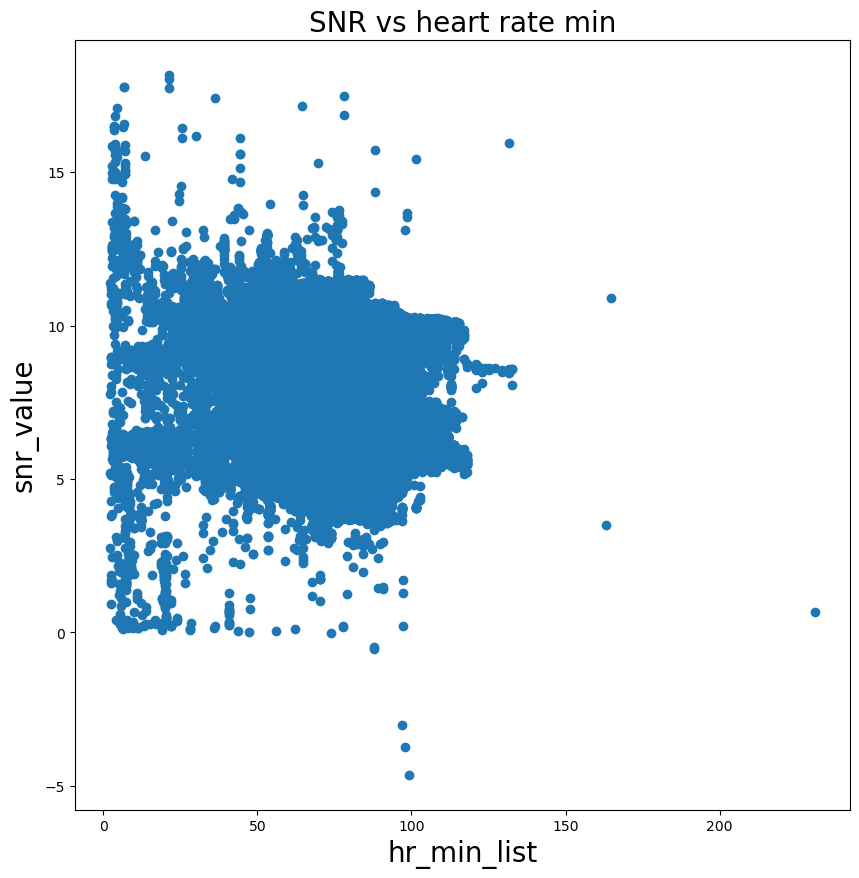

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(hr_min_list,snr_list)
plt.xlabel("hr_min_list",fontsize=20)
plt.ylabel("snr_value",fontsize=20)
plt.title("SNR vs heart rate min",fontsize=20)
plt.savefig(OUTPUT_DIR + "SNR_VS_hr_min.png")

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(hr_max_list,snr_list)
plt.xlabel("hr_max_list",fontsize=20)
plt.ylabel("snr_value",fontsize=20)
plt.title("SNR vs heart rate max",fontsize=20)
plt.savefig(OUTPUT_DIR + "SNR_VS_hr_max.png")